# Keras Notebook

This notebook allows us to train detector data using a CNN model using binary classsification. The purpose of this model is to distinguish between ZvvHbb images and JZ0W images. 

In order to do this we must first convert our data into a convenient format that allows us to load it into a CNN using the Keras API. Then it is a matter of using a convenient CNN model to classify the images.

In [1]:
import numpy as np
import pandas as pd 
import h5py
import convert_data

import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.utils import shuffle

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
np.random.seed(7)

Using TensorFlow backend.


In [2]:
#This loads all of our data and gives us our images and labels in the format we need

images, images_first_group, images_individual, labels = convert_data.images_and_labels()

x_tr, x_val, y_tr, y_val = train_test_split(images, labels, test_size=0.5, random_state=42)
x_val, x_te, y_val, y_te = train_test_split(x_val, y_val, test_size=0.1, random_state=42)

# x_tr_fg, x_val_fg, y_tr_fg, y_val_fg = train_test_split(images_first_group, labels, test_size=0.5, random_state=42)
# x_val_fg, x_te_fg, y_val_fg, y_te_fg = train_test_split(x_val_fg, y_val_fg, test_size=0.1, random_state=42)

# x_tr_i, x_val_i, y_tr_i, y_val_i = train_test_split(images_individual, labels, test_size=0.5, random_state=42)
# x_val_i, x_te_i, y_val_i, y_te_i = train_test_split(x_val_i, y_val_i, test_size=0.1, random_state=42)




# Model Creation

Here we define various differen models and train them on various normalized datasets.

In [3]:
def model_one_conv_layer():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(26,32,1)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

model_1c = model_one_conv_layer()
model_1c_fg = model_one_conv_layer()
model_1c_i = model_one_conv_layer()
model_1c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 32, 32)        128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 26624)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26625     
Total params: 27,073
Trainable params: 27,009
Non-trainable params: 64
_________________________________________________________________


In [4]:
def model_two_conv_layer():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(26,32,1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

model_2c = model_two_conv_layer()
model_2c_fg = model_two_conv_layer()
model_2c_i = model_two_conv_layer()
model_2c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 32, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 32, 32)        9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 32, 32)        128       
_________________________________________________________________
flatten_4 (Flatten)          (None, 26624)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26625     
Total params: 36,321
Trainable params: 36,257
Non-trainable params: 64
_________________________________________________________________


In [5]:
def model_one_conv_one_max():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(26,32,1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

model_1c1m = model_one_conv_one_max()
model_1c1m_fg = model_one_conv_one_max()
model_1c1m_i = model_one_conv_one_max()
model_1c1m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 26, 32, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 13, 16, 32)        128       
_________________________________________________________________
flatten_7 (Flatten)          (None, 6656)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6657      
Total params: 7,105
Trainable params: 7,041
Non-trainable params: 64
_________________________________________________________________


In [6]:
def model_two_conv_layer():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(26,32,1)))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

model_2c2m = model_two_conv_layer()
model_2c2m_fg = model_two_conv_layer()
model_2c2m_i = model_two_conv_layer()
model_2c2m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 32, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 8, 32)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 6, 8, 32)          128       
_________________________________________________________________
flatten_10 (Flatten)         (None, 1536)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 1537      
Total para

In [7]:
reduce_lr = LearningRateScheduler(lambda x: 1e-2 * 0.7 ** x)
batch_size = 32
epochs = 50

In [8]:
# history_1c = model_1c.fit(x_tr, y_tr, validation_data = (x_val, y_val) ,epochs = epochs, verbose=2, callbacks = [reduce_lr], batch_size = batch_size)
# history_fg = model_fg.fit(x_tr_fg, y_tr_fg, validation_data = (x_val_fg, y_val_fg) ,epochs = epochs, verbose=2, callbacks = [reduce_lr], batch_size = batch_size)
# history_1c_fg = model_1c_fg.fit(x_tr_fg, y_tr_fg, validation_data = (x_val_fg, y_val_fg) ,epochs = epochs, verbose=2, callbacks = [reduce_lr], batch_size = batch_size)
# history_i = model_i.fit(x_tr_i, y_tr_i, validation_data = (x_val_i, y_val_i) ,epochs = epochs, verbose=2, callbacks = [reduce_lr], batch_size = batch_size)

In [9]:
history_2c2m = model_2c2m.fit(x_tr, y_tr, validation_data = (x_val, y_val) ,epochs = epochs, verbose=2, callbacks = [reduce_lr], batch_size = batch_size)

Train on 1000 samples, validate on 900 samples
Epoch 1/50
 - 4s - loss: 0.5270 - acc: 0.7810 - val_loss: 0.4507 - val_acc: 0.8222
Epoch 2/50
 - 1s - loss: 0.4145 - acc: 0.8410 - val_loss: 0.4648 - val_acc: 0.8133
Epoch 3/50
 - 1s - loss: 0.3579 - acc: 0.8670 - val_loss: 0.4611 - val_acc: 0.8267
Epoch 4/50
 - 1s - loss: 0.3455 - acc: 0.8650 - val_loss: 0.4150 - val_acc: 0.8444
Epoch 5/50
 - 1s - loss: 0.3093 - acc: 0.8800 - val_loss: 0.3887 - val_acc: 0.8511
Epoch 6/50
 - 1s - loss: 0.2721 - acc: 0.9020 - val_loss: 0.3933 - val_acc: 0.8533
Epoch 7/50
 - 1s - loss: 0.2435 - acc: 0.9100 - val_loss: 0.3904 - val_acc: 0.8533
Epoch 8/50
 - 1s - loss: 0.2340 - acc: 0.9070 - val_loss: 0.3916 - val_acc: 0.8489
Epoch 9/50
 - 1s - loss: 0.2208 - acc: 0.9240 - val_loss: 0.3910 - val_acc: 0.8556
Epoch 10/50
 - 1s - loss: 0.2199 - acc: 0.9150 - val_loss: 0.3919 - val_acc: 0.8544
Epoch 11/50
 - 1s - loss: 0.2109 - acc: 0.9260 - val_loss: 0.3923 - val_acc: 0.8533
Epoch 12/50
 - 1s - loss: 0.2090 - acc

Baseline Error: 9.00%


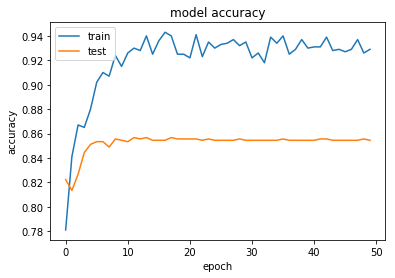

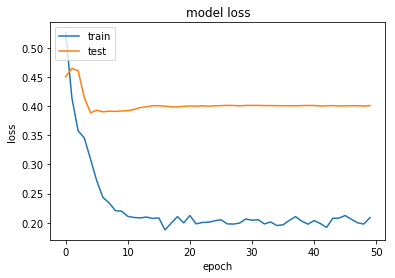

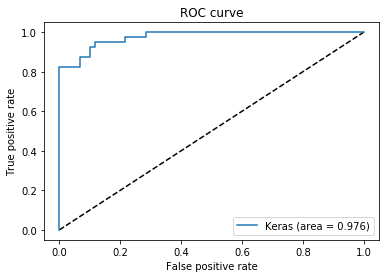

In [10]:
scores = model_2c2m.evaluate(x_te, y_te, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

plt.plot(history_2c2m.history['acc'])
plt.plot(history_2c2m.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_2c2m.history['loss'])
plt.plot(history_2c2m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

from sklearn.metrics import roc_curve

y_pred_keras = model_2c2m.predict(x_te).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_te, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Conversion to Tensorflow File

We need a .pb file in order to run convert our models using the DNNDK (Deep Neural Network Development Kit)

We create a frozen graph and use this to get our model.pb file


In [11]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [12]:
from keras import backend as K
import tensorflow as tf

In [13]:
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model_2c2m.outputs])

INFO:tensorflow:Froze 240 variables.
INFO:tensorflow:Converted 240 variables to const ops.


In [14]:
tf.train.write_graph(frozen_graph, "Tensorflow_model", "my_model.pb", as_text=False)

'Tensorflow_model/my_model.pb'

In [15]:
from PIL import Image

# Saving some Images

This saves 100 validation images and 100 test images 

In [16]:
import matplotlib

val_100 = x_val[:100].reshape(-1, 26, 32)
for i, val_image in enumerate(val_100):
    matplotlib.image.imsave('val_images/' + str(i) + '_val.jpeg',val_image)
    
test_100 = x_te.reshape(-1, 26, 32)    
for i, test_image in enumerate(test_100):
    matplotlib.image.imsave('test_images/' + str(i) + '_test.jpeg',test_image)